# Conjugate-NonConjugate Varialtional Message Passsing: a tutorial


*Table of contents*
1. [Introduction](#Introduction)
2. [Usage of CVI inside the GraphPPL Model specification](#Usage-of-CVI-inside-the-GraphPPL-Model-specification)
3. [Limitations](#Limitations)
4. [Inference](#Inference)
5. [Extension](#Extension)

## Introduction

In this tutorial, we show how to excute VMP in models with delta factors of the form $\delta(f(x_{1}, \dots, x_{n}) - y)$ (`f` arbitrary differentiable function) inside `ReactiveMP`.
The `ReactiveMP` implemented the Conjugate-NonConjugate Variational Inference (CVI) inside factor graphs carefully following the paper [Probabilistic programming with stochastic variational message passing](https://reader.elsevier.com/reader/sd/pii/S0888613X22000950?token=EFB22E01793BD0BF73EECC9702C315644969403BD44B13FA850E9F66C8A49E88C0D5C68A9AD03301C609DA443DB33F80&originRegion=eu-west-1&originCreation=20221027115856) (see it for implementation details).

More specifically the tutorial shows:
1. [How specify](#Model-specification) a `Delta factor` of the form $\delta(f(x_{1}, \dots, x_{n}) - y)$ inside the `@model` macro with CVI inference procedure
2. [What limitation](#Limitations) the CVI has
3. [Show several inference examples](#Inference)
4. [How to extend](#Extension) it from the user perspective

## Usage of CVI inside the GraphPPL Model specification

Suppose we have a function `f`:

```
    f(x, y, ..., z) = ...
```

And we want to specify a `GraphPPL` model with `@model` macro where we want define a `Delta factor` with this `f`:

```
@model function model_name(...)
    ... some where here inputs (x, y, ..., z) defiened
    out ~ f(x, y, ..., z)
    ...    
end


@meta function model_meta(...)
    f() -> CVI(rng, n_iterations, n_samples, Descent(learning_rate))
end
```

If you want to see a detailed example at this point, go to [Inference](#Inference) section. 

The magic happens inside the `@meta` block: where we specify through `meta` parameter that `ReactiveMP` should run `CVI` for the messages sent through the `out ~ f(x, y, ..., z)` node.

So to specify it for `out ~ f(x, y, ..., z)` node you need set `meta` to `CVI(...)` inside `@meta` block: `f() -> CVIApproximation(rng, n_samples, n_iterations, Descent(learning_rate))` in the above example.

The `CVI` structure serves for two reasons:
1. Marker that the `CVI` rules need to be called
2. Container of the `CVI` hyperparameters.

`CVI` procedure has 4 hyperparameters:
1. random number generator, which will be called inside the `CVI` procedure (`rng`)
2. number of samples to use for the out message approximation (`n_samples`)
3. number of iterations of the CVI procedure (`n_iterations`)
4. optimizer, which will be used to perform the CVI step (`Descent(learning_rate)`)

## Limitations

There are several main limitations for the `CVI` procedure that you need to satisfy:
1. The `out` interface of the `Delta` factor are factorized out in other nodes to which it's connected.
2. The messages on input interfaces (`x, y, ..., z`) are from the exponential family distributions.

In `ReactiveMP`, you can obtain the first if you use appropriate nodes (`Normal`, `Gamma`, `Bernoulli`, etc) and second assumption through `@constraints` macro:

```
@model function model_name(...)
 ...
 out ~ f(x, y, ..., z)
 ... ~ Node2(p1,..., out, pn) # some node that is using the out interface
 ... 
end

constraints = @constraints begin
 q(out, p1, ..., pn) = q(out)q(p1,...,pn)
 ...
end;

@meta function model_meta(...)
    f(x, y, ..., z) -> CVIApproximation(rng, n_iterations, n_samples, Descent(learning_rate))
end
```

Note that only some exponential family distributions are implemented. If you want to add one not implemented inside `ReactiveMP` read this [example](###Adding-a-custom-implementation-for-an-instance-from-exponential-family-distribution).


## Inference

This section shows how one can use the `CVI` in the wild.
But the model is not of particular interest here, but rather an excellent example on which it is possible to show:
1. How to specify a model with `CVI.`
2. How to satisfy `CVI` constraints.
3. How to run the inference.

### Model specification

For our show we will use the following model:

$$
\begin{aligned}
 p(\tau) & = \text{Gamma}(1, \text{tiny}),\\
 p(\theta) & = \text{Gamma}(1, \text{tiny}),\\
 p(z_i|z_{i - 1}) & = \mathcal{N}(z_i| z_{i - 1} + 1, \tau),\\
 p(y_i|z_i) & = \mathcal{N}(y_i|(z_i - s)^2, \theta),
\end{aligned}
$$

where $z_i$ are hidden states, $y_i$ are noisy nonlinear observations, $\tau$, and $\theta$ are priors for state transition noise and observation noise precision, respectively, and s is some constant (it will be selected further, and it's not essential for our discussion).

So now we can specify our model with `GraphPPL` package.

First, we start with importing all needed packages:

In [310]:
using ReactiveMP, Rocket, GraphPPL
using Random
using Plots # used only for vizulization
using Flux  # used only inside CVI

`ReactiveMP` is supporting `Flux` optimizer out of the box.

Please check this [example](#using-a-custom-optimizer) if you want to extend it to a custom structure.

In [312]:
sensor_location = 53
function f(z)
    (z - sensor_location)^2
end

@model function sensor_based_observation(T)

    z = randomvar(T)
    y = datavar(Float64, T)

    τ ~ GammaShapeRate(1.0, 1.0)
    θ ~ GammaShapeRate(1.0, 1.0)
    
    z[1] ~ NormalMeanPrecision(0, τ)
    y[1] ~ NormalMeanPrecision(f(z[1]), θ)

    for t in 2:T
        z[t] ~ NormalMeanPrecision(z[t-1] + 1, τ)
        y[t] ~ NormalMeanPrecision(f(z[t]), θ)
    end

    return z, y
end

@meta function model_meta(rng, n_samples, n_iterations, optimizer)
    f() -> CVI(rng, n_samples, n_iterations, optimizer, true)
end

model_meta (generic function with 1 method)

So most important part for us in this tutorial is $p(y_i|z_i) = \mathcal{N}(y_i| (z_{i} - s)^{2}, \theta)$ which is implemeted inside the model in the following way:
```
@model function sensor_based_observation(T)
    ...
    y[1] ~ NormalMeanPrecision(f(z[1]), θ)
    for t in 2:T
        ...
        y[t] ~ NormalMeanPrecision(f(z[t]), θ)
    end
    ...
end
```

And `@meta` block where we specify that `CVI` need to be used:
```
@meta function model_meta(rng, n_samples, n_iterations, optimizer)
    f() -> CVI(rng, n_samples, n_iterations, optimizer, true)
end
```

### Constraints

In our model, `z` variables are connected `Delta` factors. So to run it with `CVI` we need to factorize out them in other nodes where they are connected through the CVI delta factors:

Let's specify these places in our model: `z[t] ~ NormalMeanPrecision(f(z[t]), θ)` and `y[1] ~ NormalMeanPrecision(f(z[1]), θ)`

So to run `CVI`, we need to add a constraint `q(z, θ) = q(z)q(θ)`

Note, you can skip assing to a temporary variable `out ~ f(z[t])` explicetly if you have only one input interface: in this case, input and out can be interchanged.

In [313]:
constraints = @constraints begin
    q(z, θ) = q(z)q(θ) # CVI
    q(z, τ) = q(z)q(τ) # the mean-field assumption around normal node
end;

### Run inference

Next step, is to generate some synthetic data:

In [314]:
seed = 123

rng = MersenneTwister(seed)

P = 5
sensor_var = 5

# For large `n` apply: smoothing(model_options(limit_stack_depth = 500), ...)
T = 50

hidden = collect(1:T)
data   = (hidden + rand(rng, NormalMeanVariance(0.0, sqrt(P)), T));
transformed = (data .- sensor_location).^2 + rand(rng, NormalMeanVariance(0.0, sensor_var), T);

Let's plot our synthetic dataset. 
The blue line represents our hidden state we want to estimate using noisy observations, 
which are represented as dots.

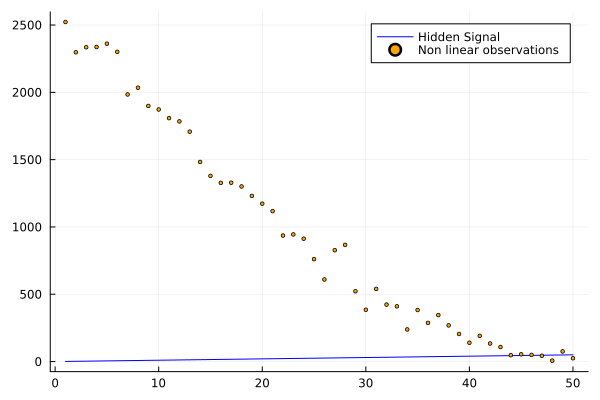

In [315]:
px = plot()

px = plot!(px, hidden, label = "Hidden Signal", color = :blue)
px = scatter!(px, transformed, label = "Non linear observations", markersize = 2, color = :orange)

plot(px)

To run inference we will use `inference` function from `ReactiveMP`.
Note, that for running inference for this model we need to init marginals for z, $\theta$, $\tau$, and init z messages.

In [316]:
res = inference(
    model = Model(sensor_based_observation, T),
    data = (y = transformed,),
    iterations = 30,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = constraints,
    initmessages = (z = NormalMeanVariance(0, P),),
    initmarginals = (z = NormalMeanVariance(0, P), τ = GammaShapeRate(1.0, 1.0), θ = GammaShapeRate(1.0, 1.0),),
    meta = model_meta(rng, 1000, 100, Flux.Descent(0.01))
)

┌ Warning: Meta specification `f() -> CVIApproximation{MersenneTwister, Descent}(MersenneTwister(123, (0, 1002, 0, 100)), 1000, 100, Descent(0.01), true)` specifies node entry as `f`, but model has no factor node `f`. Use `warn = false` option during constraints specification to suppress this warning.
└ @ ReactiveMP /Users/mykola/repos/ReactiveMP.jl/src/constraints/meta/meta.jl:102


Inference results:
-----------------------------------------
Free Energy: Real[532.002, 352.599, 330.324, 321.933, 316.369, 313.364, 311.382, 309.941, 310.005, 310.408  …  311.476, 311.044, 311.281, 311.378, 311.038, 311.297, 311.513, 311.317, 311.44, 311.401]
-----------------------------------------
z = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=5.7...


Let's check the inference quality graphically.

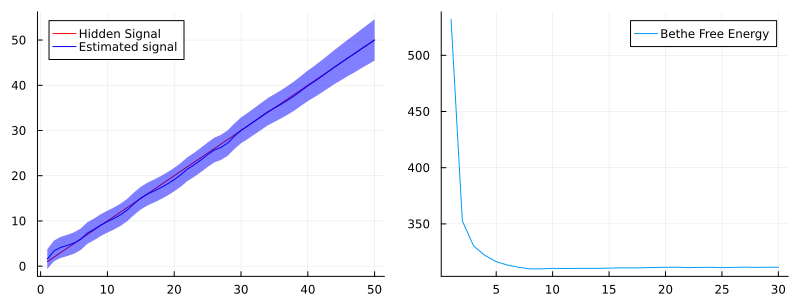

In [317]:
px = plot()

px = plot!(px,  hidden, label = "Hidden Signal", color = :red)
px = plot!(px,  map(mean, res.posteriors[:z]), ribbon = std.(9 .* res.posteriors[:z]).|> sqrt, fillalpha = 0.5, label = "Estimated signal", color = :blue)

px = plot!(px, legend=:topleft)
pfe = plot(res.free_energy, label = "Bethe Free Energy")

plot(px, pfe, size = (800, 300))

## Extension

### Adding a custom implementation for an instance from exponential family distribution

You might need a distribution from the exponential distribution family, which has not yet been implemented in `ReactiveMP.`

This section shows how you can implement it yourself.

This example implements `Beta distribution`.

To add a new distribution, we need to implement the following:

1. auxiliary structure for storing `Beta` natural parameters: it is `BetaNaturalParameters` in our example
2. `isproper`: the domain check for `BetaNaturalParameters`
3. auxiliary functions that convert `BetaNaturalParameters` to vector, distribution, and vice-versa
4. `lognormalizer` and `logpdf` for `BetaNaturalParameters`
5. subtraction for `BetaNaturalParameters` 

In [318]:
using ReactiveMP, Rocket, GraphPPL
using Distributions
using Base
using Random, StableRNGs

using Flux              # only used to import optimzers
using SpecialFunctions  # only used for loggamma computation
using Plots             # only used for visualisatio

`BetaNaturalParameters` structure

In [319]:
struct BetaNaturalParameters{T <: Real} <: NaturalParameters
    α::T
    β::T
end

`isproper` functions

In [320]:
ReactiveMP.isproper(params::BetaNaturalParameters) = (params.α > zero(params.α)) && (params.β > zero(params.β))

Needed axillary "convert" functions

In [321]:
ReactiveMP.naturalparams(dist::Beta) = BetaNaturalParameters(dist.α, dist.β)

function Base.convert(::Type{Distribution}, η::BetaNaturalParameters)
    return Beta(η.α, η.β)
end

function Base.vec(p::BetaNaturalParameters)
    return [p.α, p.β]
end

ReactiveMP.as_naturalparams(::Type{T}, args...) where {T <: BetaNaturalParameters} =
    convert(BetaNaturalParameters, args...)

function BetaNaturalParameters(v::AbstractVector{T}) where {T <: Real}
    @assert length(v) === 2 "`BetaNaturalParameters` must accept a vector of length `2`."
    return BetaNaturalParameters(v[1], v[2])
end

Base.convert(::Type{BetaNaturalParameters}, vector::AbstractVector) =
    convert(BetaNaturalParameters{eltype(vector)}, vector)

Base.convert(::Type{BetaNaturalParameters{T}}, vector::AbstractVector) where {T} =
    BetaNaturalParameters(convert(AbstractVector{T}, vector))

`lognormalizer` and `logpdf`

In [322]:
ReactiveMP.lognormalizer(params::BetaNaturalParameters) = loggamma(params.α) + loggamma(params.β) - loggamma(params.α + params.β) 
ReactiveMP.logpdf(params::BetaNaturalParameters, x) = x * (params.α - 1) + (1-x) * (params.β - 1) - lognormalizer(params) 

Implemeting subtraction for `BetaNaturalParameters`

In [323]:
function Base.:-(left::BetaNaturalParameters, right::BetaNaturalParameters)
    return BetaNaturalParameters(
        left.α - right.α,
        left.β - right.β
    )
end

Now, we can specify a model with `Beta distribution` inside `Delta` factor.

Let's try to do it with a model:
$$
\begin{aligned}
 p(x) & = \text{Beta}(1, 1),\\
 p(y_{i}) & = \mathcal{N}(x, 1),\\
\end{aligned}
$$

This model is not particularly interesting, but it is enough to demonstrate the inference of `Beta` distribution parameters trough `CVI.`

Note that `Normal` and `Beta` are not a conjugate pair, and even with the `identity` function, the analytical inference is impossible.

Generation of some syntatic data for the model.

In [324]:
rng = StableRNG(123)

num_samples = 1000
mean_point = 0.75
y = rand(rng, NormalMeanVariance(mean_point, 0.1), num_samples);

Creating a model specification with `@model` macro.

In [325]:
@model function normal_with_beta_mean(num_observations)
    observations = datavar(Float64, num_observations) 
    beta ~ Beta(2, 1)
    mean ~ identity(beta)
    observations .~ NormalMeanVariance(mean, 0.1)
end

@meta function beta_model_meta(cvi_rng, cvi_num_samples, cvi_num_iterations, optimizer)
    identity() -> CVI(cvi_rng, cvi_num_samples, cvi_num_iterations, optimizer)
end

beta_model_meta (generic function with 1 method)

To run inference we will use `inference` function from `ReactiveMP`.
Note, that for running inference for this model we need to init message for `beta`.

In [326]:
res = inference(
    model = Model(normal_with_beta_mean, num_samples),
    data = (observations = y,),
    iterations = 5,
    free_energy = true,
    returnvars = (beta = KeepLast(),),
    initmessages = (beta = Beta(2, 1),),
    meta = beta_model_meta(rng, 10, 50, Descent(0.1))
)

┌ Warning: Meta specification `identity() -> CVIApproximation{StableRNGs.LehmerRNG, Descent}(StableRNGs.LehmerRNG(state=0xd6f859a95fee77c83770c0056745b5bf), 10, 50, Descent(0.1), false)` specifies node entry as `identity`, but model has no factor node `identity`. Use `warn = false` option during constraints specification to suppress this warning.
└ @ ReactiveMP /Users/mykola/repos/ReactiveMP.jl/src/constraints/meta/meta.jl:102


Inference results:
-----------------------------------------
Free Energy: Real[266.744, 264.187, 265.196, 263.197, 265.261]
-----------------------------------------
beta = Beta{Float64}(α=593260.3384086783, β=238037.05412953597)


In [327]:
mean(res.posteriors[:beta]), mean_point

(0.7136559596286793, 0.75)

The inference is working!
As we can see by mean comparison with our noisy observed point: we obtained a reasonable `Beta` posterior.

### Using a custom optimizer

`CVI` supports only `Flux` optimizers out of the box.

Here it is shown how to extend it for a some structure.

Suppose we have `CustomDescent` structure which we want to use inside `CVI`.

To do it we need to implement `ReactiveMP.cvi_update!(opt::CustomDescent, λ, ∇)`.

`ReactiveMP.cvi_update!` incapsulates gradient step:
1. `opt` is used to select your flow
2. `λ` is a current point
3. `∇` is a gradient value computed inside `CVI`.

In [328]:
struct CustomDescent 
    learning_rate::Float64
end

function ReactiveMP.cvi_update!(opt::CustomDescent, λ, ∇)
    return vec(λ) - (opt.learning_rate .* vec(∇))
end

Let's try to apply it to a model:
$$
\begin{aligned}
 p(x) & = \mathcal{N}(0, 1),\\
 p(y_{i}) & = \mathcal{N}(x^2, 1),\\
\end{aligned}
$$

This model is not particularly interesting, but it show how to use `CVI` approximation with a custom structure.

Let's generate some syntatic data for the model

In [329]:
rng = StableRNG(123)
num_samples = 100

mean_point = 19
observations = rand(rng, NormalMeanVariance(mean_point^2, 1), num_samples);

To create a model we use `GraphPPL` package and `@model` macro:

In [330]:
f(x) = x ^ 2
@model function normal_square_mean(num_observations)
    observations = datavar(Float64, num_observations)
    latent ~ NormalMeanPrecision(0, 100)
    mean ~ f(latent)
    observations .~ NormalMeanVariance(mean, 1)
end

@meta function normal_normal_model_meta(rng, num_samples, num_iterations, optimizer)
    f() ->  CVI(rng, num_samples, num_iterations, optimizer, false)
end

normal_normal_model_meta (generic function with 1 method)

Note we are using optimizer, as a model parameter: `normal_square_mean(..., optimizer)`.

We will use the `inference` function from `ReactiveMP` to run inference, where we provide an instance of the `CustomDescent` structure:
```
... = inference(
model = Model(..., CustomDescent(0.1)),
...)
```

**Side note**:
To run the inference for this model, we do not need to init the message for `latent` but with this initialization, the inference procedure is more stable.

In [331]:
res = inference(
    model = Model(normal_square_mean, num_samples),
    data = (observations = observations,),
    iterations = 10,
    free_energy = true,
    initmessages = (latent = NormalMeanVariance(0, 100),),
    meta = model_meta(rng, 100, 100, CustomDescent(0.1))
)

mean(res.posteriors[:latent][end]), mean_point

┌ Warning: Meta specification `f() -> CVIApproximation{StableRNGs.LehmerRNG, CustomDescent}(StableRNGs.LehmerRNG(state=0xef08b8a6824a5b7570a530ef68e4a0ab), 100, 100, CustomDescent(0.1), true)` specifies node entry as `f`, but model has no factor node `f`. Use `warn = false` option during constraints specification to suppress this warning.
└ @ ReactiveMP /Users/mykola/repos/ReactiveMP.jl/src/constraints/meta/meta.jl:102


(-18.99115645613996, 19)

The inference is working! 

**Note**: 
$x^2$ can not be inverted; the sign information can be lost: -19 and 19 are both equally good solutions.